In [6]:
# Cell 1: Import Libraries and Setup Paths
import cudf
import cupy as cp
from sklearn.svm import OneClassSVM
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define paths
processed_train_path = '/root/autodl-tmp/projects/USL_NSL/dataset/processed/bin/KDDTrain_processed.csv'
processed_test_path = '/root/autodl-tmp/projects/USL_NSL/dataset/processed/bin/KDDTest_processed.csv'
train_labels_path = '/root/autodl-tmp/projects/USL_NSL/dataset/processed/bin/KDDTrain_labels.csv'
test_labels_path = '/root/autodl-tmp/projects/USL_NSL/dataset/processed/bin/KDDTest_labels.csv'

In [7]:
# Cell 2: Load and Prepare Data with Feature Scaling
print("Loading training data...")
# Load features
df_train = pd.read_csv(processed_train_path)
X = df_train.values

# Load labels
y_train = pd.read_csv(train_labels_path)
y_train_binary = y_train['label'].values

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y_train_binary)

# Split data into training and validation sets
X_train, X_val, y_train_split, y_val = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)

Loading training data...


In [8]:
# Cell 3: Initialize and Train Model with Optimized Parameters
print("\nTraining One-Class SVM model...")
oc_svm = OneClassSVM(
    kernel='rbf',        # Radial basis function kernel
    nu=0.35,             # Increased nu to improve recall
    gamma='scale',       # Kernel coefficient
    cache_size=1000,     # Increased cache size
    max_iter=1000,       # Increased max iterations
    tol=1e-4             # Set a smaller tolerance for convergence
)

# Fit the model on training set only
oc_svm.fit(X_train)


Training One-Class SVM model...


/root/miniconda3/envs/sl-nsl-env/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


OneClassSVM(cache_size=1000, max_iter=1000, nu=0.35, tol=0.0001)

In [9]:
# Cell 4: Evaluate on Training and Validation Sets
print("\nEvaluating on Training Set...")
# Get predictions and convert to match binary labels
train_predictions = oc_svm.predict(X_train)
train_labels = (-train_predictions/2 + 0.5).astype(int)

# Calculate unsupervised evaluation metrics
silhouette_avg = silhouette_score(X_train, train_labels)
davies_bouldin_idx = davies_bouldin_score(X_train, train_labels)

print("\nUnsupervised Evaluation Metrics:")
print(f"Silhouette Score: {silhouette_avg:.3f}")
print(f"Davies-Bouldin Index: {davies_bouldin_idx:.3f}")

# Print prediction distribution
print("\nPrediction distribution (Training Set):")
unique, counts = np.unique(train_labels, return_counts=True)
print(dict(zip(unique, counts)))

train_accuracy = accuracy_score(y_train_split, train_labels)
train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(y_train_split, train_labels, average='binary')
train_conf_matrix = confusion_matrix(y_train_split, train_labels)
train_class_report = classification_report(y_train_split, train_labels)

print("\nSupervised Evaluation Metrics (Training Set):")
print(f"Accuracy: {train_accuracy:.3f}")
print(f"Precision: {train_precision:.3f}")
print(f"Recall: {train_recall:.3f}")
print(f"F1-score: {train_f1:.3f}")
print("\nConfusion Matrix (Training Set):")
print(train_conf_matrix)
print("\nClassification Report (Training Set):")
print(train_class_report)

# Evaluate on validation set
val_predictions = oc_svm.predict(X_val)
val_labels = (-val_predictions/2 + 0.5).astype(int)

print("\nEvaluating on Validation Set...")
print("\nPrediction distribution (Validation Set):")
unique, counts = np.unique(val_labels, return_counts=True)
print(dict(zip(unique, counts)))

val_accuracy = accuracy_score(y_val, val_labels)
val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(y_val, val_labels, average='binary')
val_conf_matrix = confusion_matrix(y_val, val_labels)
val_class_report = classification_report(y_val, val_labels)

print("\nSupervised Evaluation Metrics (Validation Set):")
print(f"Accuracy: {val_accuracy:.3f}")
print(f"Precision: {val_precision:.3f}")
print(f"Recall: {val_recall:.3f}")
print(f"F1-score: {val_f1:.3f}")
print("\nConfusion Matrix (Validation Set):")
print(val_conf_matrix)
print("\nClassification Report (Validation Set):")
print(val_class_report)


Evaluating on Training Set...

Unsupervised Evaluation Metrics:
Silhouette Score: 0.241
Davies-Bouldin Index: 2.728

Prediction distribution (Training Set):
{0: 67255, 1: 40493}

Supervised Evaluation Metrics (Training Set):
Accuracy: 0.526
Precision: 0.534
Recall: 0.402
F1-score: 0.459

Confusion Matrix (Training Set):
[[35086 18868]
 [32169 21625]]

Classification Report (Training Set):
              precision    recall  f1-score   support

           0       0.52      0.65      0.58     53954
           1       0.53      0.40      0.46     53794

    accuracy                           0.53    107748
   macro avg       0.53      0.53      0.52    107748
weighted avg       0.53      0.53      0.52    107748


Evaluating on Validation Set...

Prediction distribution (Validation Set):
{0: 16823, 1: 10115}

Supervised Evaluation Metrics (Validation Set):
Accuracy: 0.528
Precision: 0.542
Recall: 0.404
F1-score: 0.463

Confusion Matrix (Validation Set):
[[8754 4635]
 [8069 5480]]

Classif

In [10]:
# Cell 5: Evaluate on Test Set with Feature Scaling
print("\nEvaluating on test set...")
# Load test data
df_test = pd.read_csv(processed_test_path)
X_test = df_test.values

# Scale test data
X_test_scaled = scaler.transform(X_test)

# Load test labels
y_test = pd.read_csv(test_labels_path)
y_test_binary = y_test['label'].values

# Get predictions for test data
raw_predictions_test = oc_svm.predict(X_test_scaled)
labels_test = (-raw_predictions_test/2 + 0.5).astype(int)

# Calculate unsupervised evaluation metrics
silhouette_avg = silhouette_score(X_test, labels_test)
davies_bouldin_idx = davies_bouldin_score(X_test, labels_test)

print("\nUnsupervised Evaluation Metrics:")
print(f"Silhouette Score: {silhouette_avg:.3f}")
print(f"Davies-Bouldin Index: {davies_bouldin_idx:.3f}")

# Print prediction distribution
print("\nPrediction distribution (Test Set):")
unique, counts = np.unique(labels_test, return_counts=True)
print(dict(zip(unique, counts)))

# Calculate supervised metrics for test set
accuracy_test = accuracy_score(y_test_binary, labels_test)
precision_test, recall_test, f1_test, _ = precision_recall_fscore_support(y_test_binary, labels_test, average='binary')
conf_matrix_test = confusion_matrix(y_test_binary, labels_test)
class_report_test = classification_report(y_test_binary, labels_test)

print("\nSupervised Evaluation Metrics (Test Set):")
print(f"Accuracy: {accuracy_test:.3f}")
print(f"Precision: {precision_test:.3f}")
print(f"Recall: {recall_test:.3f}")
print(f"F1-score: {f1_test:.3f}")
print("\nConfusion Matrix:")
print(conf_matrix_test)
print("\nClassification Report:")
print(class_report_test)


Evaluating on test set...

Unsupervised Evaluation Metrics:
Silhouette Score: 0.180
Davies-Bouldin Index: 2.031

Prediction distribution (Test Set):
{0: 8955, 1: 13589}

Supervised Evaluation Metrics (Test Set):
Accuracy: 0.800
Precision: 0.806
Recall: 0.854
F1-score: 0.829

Confusion Matrix:
[[ 7079  2632]
 [ 1876 10957]]

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.73      0.76      9711
           1       0.81      0.85      0.83     12833

    accuracy                           0.80     22544
   macro avg       0.80      0.79      0.79     22544
weighted avg       0.80      0.80      0.80     22544



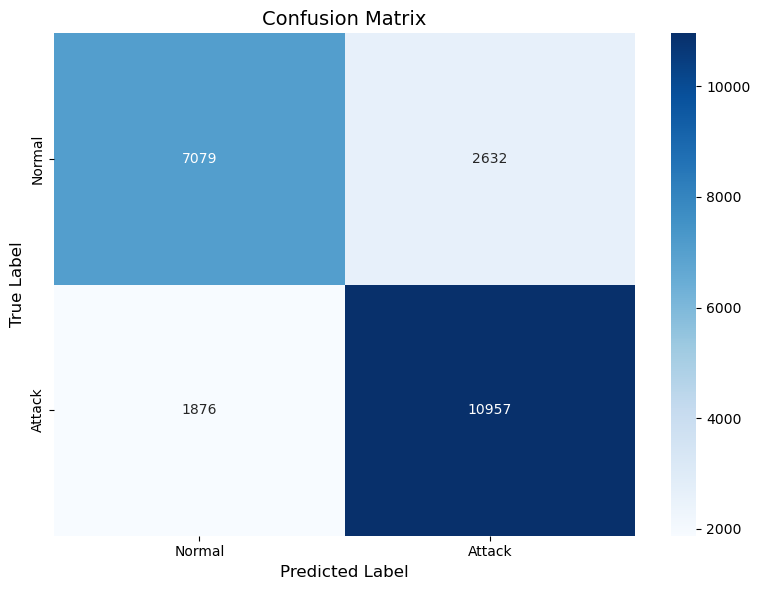

In [11]:
# Create confusion matrix
plt.figure(figsize=(8, 6))

# Convert CuPy array to NumPy if needed
if hasattr(conf_matrix_test, 'get'):
    conf_matrix_np = conf_matrix_test.get()
else:
    conf_matrix_np = conf_matrix_test

# Define class names (based on your data being a binary problem)
class_names = ['Normal', 'Attack']  # or use numeric labels ['0', '1']

# Create heatmap
sns.heatmap(conf_matrix_np, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

# Add labels
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)

# Adjust layout and save
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()